In [ ]:
!pip install numpy==1.23.5 gym pygame==2.5.2 pyvirtualdisplay

# start a virtual display (needed for render() on Colab)
from pyvirtualdisplay import Display
Display().start()


In [ ]:
import gym, numpy as np, matplotlib.pyplot as plt

# CartPole with rgb_array mode so render() returns frames
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Q-learning hyperparameters
alpha, gamma = 0.1, 0.99
epsilon = 0.1
episodes = 1000

# Discretization: 4 state dims → 10 bins each
bins = [10, 10, 10, 10]
action_n = env.action_space.n

# Q-table shape: (10,10,10,10,2)
q_table = np.zeros(bins + [action_n])


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:

def discretize_state(state):
    bounds = [(-2.4,2.4), (-3.0,3.0), (-0.2,0.2), (-3.0,3.0)]
    idx = []
    for i, v in enumerate(state):
        lo, hi = bounds[i]
        frac = (v - lo) / (hi - lo)
        frac = np.clip(frac, 0, 0.999)
        idx.append(int(frac * bins[i]))
    return tuple(idx)


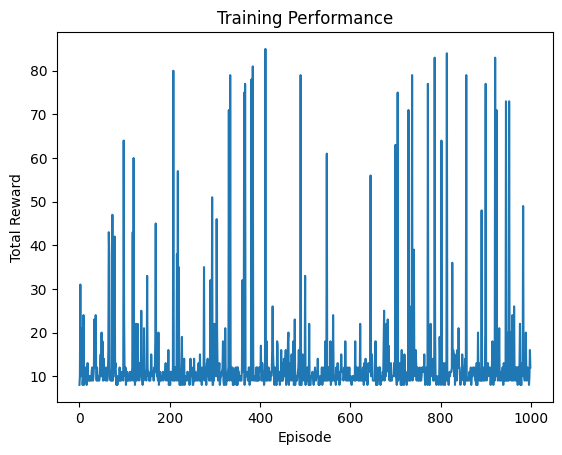

In [ ]:
rewards = []

for ep in range(episodes):
    # handle Gym.reset() returning either state or (state, info)
    reset_out = env.reset()
    obs = reset_out[0] if isinstance(reset_out, tuple) else reset_out
    state = discretize_state(obs)

    done = False
    total_r = 0

    while not done:
        # ε-greedy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        # single-step
        raw_next, reward, done, info = env.step(action)
        nxt = discretize_state(raw_next)

        # Q-update
        old = q_table[state + (action,)]
        q_table[state + (action,)] = old + alpha * (
            reward + gamma * np.max(q_table[nxt]) - old
        )

        state = nxt
        total_r += reward

    rewards.append(total_r)

# plot learning curve
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.show()


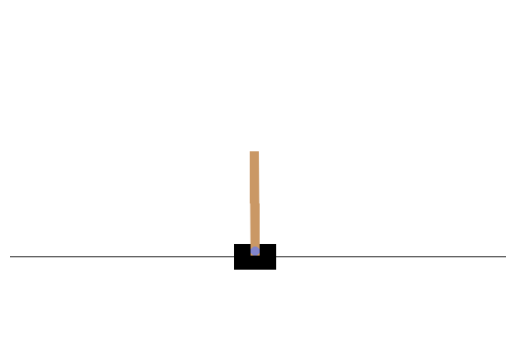

In [ ]:
from IPython import display as ipythondisp
import matplotlib.animation as animation
import numpy as np

frames = []
# reset and discretize initial state
reset_out = env.reset()
obs = reset_out[0] if isinstance(reset_out, tuple) else reset_out
state = discretize_state(obs)
done = False

while not done:
    # capture a frame
    frame = env.render()
    # if frame has a leading batch-dim, squeeze it out
    frame = np.array(frame)
    if frame.ndim == 4:
        frame = np.squeeze(frame, axis=0)
    frames.append(frame)

    # take greedy action
    action = np.argmax(q_table[state])
    raw_next, _, done, _ = env.step(action)
    state = discretize_state(raw_next)

env.close()

# build and display animation
fig = plt.figure()
im = plt.imshow(frames[0])
plt.axis('off')

def update(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=50)
ipythondisp.HTML(ani.to_jshtml())
